# PyTorch Mandelbrot
This is the PyTorch implementation of the Mandelbrot Set.
**IMPORTANT: Please refer to the "Important Note" comment at the beginning of the `mandelbrot_set_torch` function to see why we first get a `linspace` from `numpy` and then convert it to a tensor to perform the arithmetic.**

In [1]:
import torch
import numpy as np

def mandelbrot_set_torch(width, height, x_min, x_max, y_min, y_max, max_iter=100):
  # IMPORTANT NOTE: We are first getting a numpy linspace AND THEN converting in to a pytorch tensor
  # This was done because while testing, if using the default values of x/y max/min and setting
  # width and height to 10 and 10, then the pytorch values had a much higher precision than the
  # generated numpy values using their respective "linspace" methods. In this specific example,
  # the value of x_vals[6] was was 0 for numpy, but was -2.9802e-08 (close to 0, but higher precision)
  # for pytorch. This caused different outputs of the final "image" tensor/numpy-array, as the image
  # pytorch value diverged earlier. Thus, to ease with testing and ensure that both outputs are
  # the same if the logic is correct, We are converting to a pytorch tensor here.

  # This will be the tensor with the real part of the complex number
  x_vals = torch.tensor(np.linspace(x_min, x_max, width)).cuda()
  # This will contain the tensor with the imaginary values
  y_vals = torch.tensor(np.linspace(y_min, y_max, height)).cuda()
  # This will be the (height x width) grid containing the required values
  # Multiplying with 1j makes the values imaginary
  real_vals, imaginary_vals = torch.meshgrid(x_vals, y_vals, indexing="xy")
  complex_grid = real_vals + 1j*imaginary_vals
  complex_grid = complex_grid.cuda()
  # The grid containing the output, initially all 0
  image = torch.zeros((height, width)).cuda()
  # Used to check divergence: initially all 0
  z_checker = torch.zeros((height, width)).cuda()

  for n in range(max_iter):
    diverge_mask = abs(z_checker) > 2
    # The elements where the diverge_mask is True have diverged
    image[diverge_mask] = n
    # Update the z_checker for next iteration
    z_checker = (z_checker * z_checker) + complex_grid
    # Explicitly set those indices that have already diverged to 0, so that
    # they are not updated in the upcoming iterations again. Do this for the
    # complex_grid as well, as that sum is getting added in the line above
    z_checker[diverge_mask] = 0 + 0j
    complex_grid[diverge_mask] = 0 + 0j

  # Whataever remains as 0 in the image gets max_iter -- as it never diverged
  image[image == 0] = max_iter

  return image


# Default Mandelbrot
This is the default implementation (pure python) of the Mandelbrot Set. This is present here in order to verify that the pytorch implementation above is correct.

In [2]:
import numpy as np

def mandelbrot(c, max_iter=100):
    """Computes the number of iterations before divergence."""
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

def mandelbrot_set_default(width, height, x_min, x_max, y_min, y_max, max_iter=100):
    """Generates the Mandelbrot set image."""
    x_vals = np.linspace(x_min, x_max, width)
    y_vals = np.linspace(y_min, y_max, height)
    image = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            c = complex(x_vals[j], y_vals[i])
            image[i, j] = mandelbrot(c, max_iter)

    return image

# Correctness Verification
For testing, we will use square grids (N x N from the `grid_sizes` list below) and use the `x_min, x_max, y_min, y_max` values that were used in the provided code (ie, -2, 1, -1, 1 respectively)



In [3]:
grid_sizes = [256, 512, 1024, 2048]
X_MIN, X_MAX, Y_MIN, Y_MAX = -2, 1, -1, 1

for curr_size in grid_sizes:
  torch_image = mandelbrot_set_torch(curr_size, curr_size, X_MIN, X_MAX, Y_MIN, Y_MAX)
  default_image = mandelbrot_set_default(curr_size, curr_size, X_MIN, X_MAX, Y_MIN, Y_MAX)
  # Manually converting numpy array to tensor for equality check
  print(f"Equality for {curr_size}x{curr_size} grid? {torch.equal(torch_image, torch.tensor(default_image).cuda())}")

Equality for 256x256 grid? True
Equality for 512x512 grid? True
Equality for 1024x1024 grid? True
Equality for 2048x2048 grid? True


# Performance Plot

PROFILING COMPUTATION FOR torch_generate (runs=10)
Avg Time for 256x256: 0.012661022200018125
Avg Time for 512x512: 0.030808558399996855
Avg Time for 1024x1024: 0.10812428999999497
Avg Time for 2048x2048: 0.42733559330001186
PROFILING COMPUTATION FOR default_generate (runs=10)
Avg Time for 256x256: 0.28737427719999004
Avg Time for 512x512: 1.2653655646999993
Avg Time for 1024x1024: 5.200020337500002
Avg Time for 2048x2048: 20.28444709400002


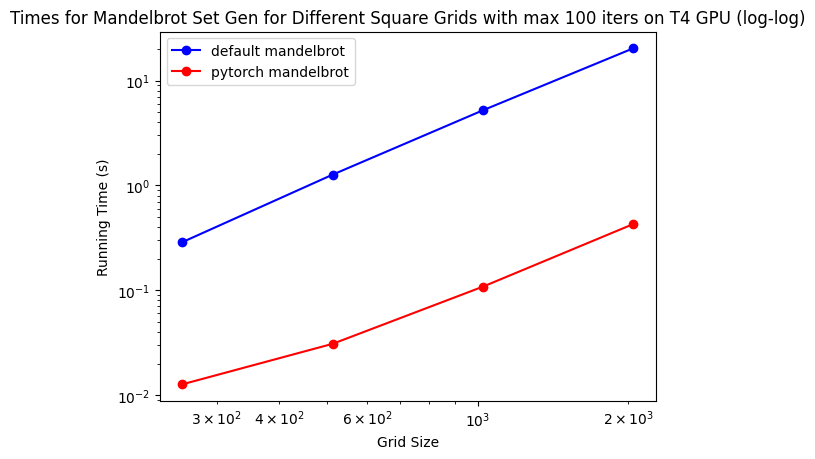

In [6]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt

def generate_image_default(width, height):
    """
    Utility to call the pure-python mandelbrot generation function
    """
    return mandelbrot_set_default(width, height, X_MIN, X_MAX, Y_MIN, Y_MAX)

def generate_image_torch(width, height):
  """
  Utility to call the pytorch mandelbrot generation function
  """
  return mandelbrot_set_torch(width, height, X_MIN, X_MAX, Y_MIN, Y_MAX)

# Dictionary for different update method implementations
GENERATE_DICT = {
    "default_generate": generate_image_default,
    "torch_generate": generate_image_torch
}

def profile_generation(generate_method_key):
    # grid sizes increase by powers of 2
    grid_sizes = [256, 512, 1024, 2048]
    # times for each of the computations (in seconds)
    times = []
    # The number of times the run will be performed for each grid size.
    # The final running time reported will be the average of these runs
    num_runs = 10

    print(f"PROFILING COMPUTATION FOR {generate_method_key} (runs={num_runs})")

    for curr_size in grid_sizes:
        total_time = 0

        for _ in range(num_runs):

            t1 = timer()
            GENERATE_DICT[generate_method_key](curr_size, curr_size)
            t2 = timer()

            total_time += (t2 - t1)

        times.append(total_time / num_runs)
        print(f"Avg Time for {curr_size}x{curr_size}: {total_time / num_runs}")

    return (grid_sizes, times)

def plot_data(running_times_default, running_times_torch, grid_sizes):
    # Create a line plot with dots at each data point
    plt.loglog(grid_sizes, running_times_default, marker='o', linestyle='-', color='b', label='default mandelbrot')
    plt.loglog(grid_sizes, running_times_torch, marker='o', linestyle='-', color='r', label='pytorch mandelbrot')


    # Adding labels to the axes
    plt.xlabel('Grid Size')
    plt.ylabel('Running Time (s)')

    # Adding a title to the plot
    plt.title('Times for Mandelbrot Set Gen for Different Square Grids with max 100 iters on T4 GPU (log-log)')
    plt.legend(loc='upper left')
    # Show the plot
    plt.show()

_, torch_times = profile_generation(generate_method_key="torch_generate")
grid_sizes, default_times = profile_generation(generate_method_key="default_generate")
plot_data(default_times, torch_times, grid_sizes)